In [1]:

# Import library

import torch
from torchvision import transforms, models
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import os
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_auc_score
import seaborn as sns
import torchsummary
import sys
plt.style.use('ggplot')

In [2]:
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, ".."))
if project_root not in sys.path:
    sys.path.append(project_root)
root_name = os.path.basename(project_root)
root_name

'deep_fake_detection'

In [17]:
from src.utils import set_seed, get_device, save_experiment_json, save_checkpoint, plot_history, performance
from src.dataloader import get_data_loaders
from src.model import Resnet18DF
from src.train import get_all_predictions, train_one_epoch, evaluate
set_seed(42)

In [4]:
CLASS = ['real', 'fake']
BATCH_SIZE = 32
DEVICE = get_device()
TASK_NAME = 'deepfake_detection'
EPOCHS_STAGE_1 = 10 # General configuration
LR_STAGE_1 = 1e-3 # General configuration
EPOCHS_STAGE_2 = 20 # General configuration
LR_STAGE_2 = 1e-5 # General configuration
MODEL_NAME = "Resnet18"

print(f"Using device: {DEVICE}")

Using device: mps


## 1. Resnet18 Training without Data Augmentation, Label Smoothing and Weight Decay

In [5]:
# Loading data with no augmentation
data_path = os.path.join(project_root, "data")
train_loader, val_loader, test_loader = get_data_loaders(root_dir = data_path, 
                                                         model_name = "resnet18", 
                                                         batch_size = BATCH_SIZE, 
                                                         use_augmentation = False)

In [6]:
def get_labels(logits):
    return torch.argmax(nn.Softmax(dim = -1)(logits), dim = 1).cpu().detach().flatten().tolist()

### 1.1 Train classifier Head only

In [7]:
model = Resnet18DF()

In [8]:
torchsummary.summary(model, (3, 224, 224), batch_size=32)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,408
       BatchNorm2d-2         [32, 64, 112, 112]             128
              ReLU-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]          36,864
       BatchNorm2d-6           [32, 64, 56, 56]             128
              ReLU-7           [32, 64, 56, 56]               0
            Conv2d-8           [32, 64, 56, 56]          36,864
       BatchNorm2d-9           [32, 64, 56, 56]             128
             ReLU-10           [32, 64, 56, 56]               0
       BasicBlock-11           [32, 64, 56, 56]               0
           Conv2d-12           [32, 64, 56, 56]          36,864
      BatchNorm2d-13           [32, 64, 56, 56]             128
             ReLU-14           [32, 64,

In [9]:
model = model.to(device=DEVICE)
optimizer = torch.optim.Adam(params=model.parameters(), lr = LR_STAGE_1)
criterion = nn.CrossEntropyLoss()

In [10]:
history = {
    "model_name": MODEL_NAME,
    "train_losses": [],
    "val_losses": [],
    "train_accuracy": [],
    "val_accuracy": [],
    "val_f1": [],
    "val_auc": [],
    "best_accuracy": 0.0,
    "best_epoch": 0,
    "MODEL_SAVED_PATH": "",
}

best_acc = 0.0

In [ ]:

MODEL_SAVED_PATH = os.path.join(
    project_root, f"model_checkpoints/{MODEL_NAME}_{TASK_NAME}.pth"
)

print(f"Training configuration for stage 1: LR = {LR_STAGE_1}, EPOCHS = {EPOCHS_STAGE_1}")

for epoch in range(EPOCHS_STAGE_1):
    # Train
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, DEVICE
    )

    # Evaluate
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(
        model, val_loader, criterion, DEVICE
    )

    print(
        f"[{epoch + 1}/{EPOCHS_STAGE_1}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}"
    )
    # Record metrics
    history["train_losses"].append(train_loss)
    history["val_losses"].append(valid_loss)
    history["train_accuracy"].append(train_acc)
    history["val_accuracy"].append(valid_acc)
    history["val_f1"].append(valid_f1)
    history["val_auc"].append(valid_auc)

    # Save Best Model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_checkpoint(model, optimizer, MODEL_SAVED_PATH)

        # Update best stats
        history["best_accuracy"] = best_acc
        history["best_epoch"] = epoch + 1
        history["MODEL_SAVED_PATH"] = MODEL_SAVED_PATH

    print(
        f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n"
    )

Training configuration for stage 1: LR = 0.001, EPOCHS = 10


Evaluating: 100%|██████████| 94/94 [00:10<00:00,  8.60it/s]


[1/10] train_acc: 0.5617 - train_loss: 0.7020 - valid_acc: 0.6040 - valid_loss: 0.6645
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Resnet18_deepfake_detection.pth
	- [current best] epoch: 1 - acc: 0.6040



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  8.61it/s]


[2/10] train_acc: 0.5789 - train_loss: 0.6888 - valid_acc: 0.6077 - valid_loss: 0.6633
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Resnet18_deepfake_detection.pth
	- [current best] epoch: 2 - acc: 0.6077



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.47it/s]


[3/10] train_acc: 0.5857 - train_loss: 0.6799 - valid_acc: 0.5909 - valid_loss: 0.6663
	- [current best] epoch: 2 - acc: 0.6077



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.31it/s]


[4/10] train_acc: 0.5855 - train_loss: 0.6815 - valid_acc: 0.5832 - valid_loss: 0.6770
	- [current best] epoch: 2 - acc: 0.6077



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.05it/s]


[5/10] train_acc: 0.5749 - train_loss: 0.6882 - valid_acc: 0.5950 - valid_loss: 0.6639
	- [current best] epoch: 2 - acc: 0.6077



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.37it/s]


[6/10] train_acc: 0.5873 - train_loss: 0.6832 - valid_acc: 0.5695 - valid_loss: 0.6892
	- [current best] epoch: 2 - acc: 0.6077



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.02it/s]


[7/10] train_acc: 0.5885 - train_loss: 0.6793 - valid_acc: 0.5862 - valid_loss: 0.6759
	- [current best] epoch: 2 - acc: 0.6077



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  8.56it/s]


[8/10] train_acc: 0.5841 - train_loss: 0.6783 - valid_acc: 0.5983 - valid_loss: 0.6612
	- [current best] epoch: 2 - acc: 0.6077



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.39it/s]


[9/10] train_acc: 0.5838 - train_loss: 0.6844 - valid_acc: 0.5832 - valid_loss: 0.6738
	- [current best] epoch: 2 - acc: 0.6077



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  8.63it/s]

[10/10] train_acc: 0.5853 - train_loss: 0.6820 - valid_acc: 0.5735 - valid_loss: 0.6712
	- [current best] epoch: 2 - acc: 0.6077



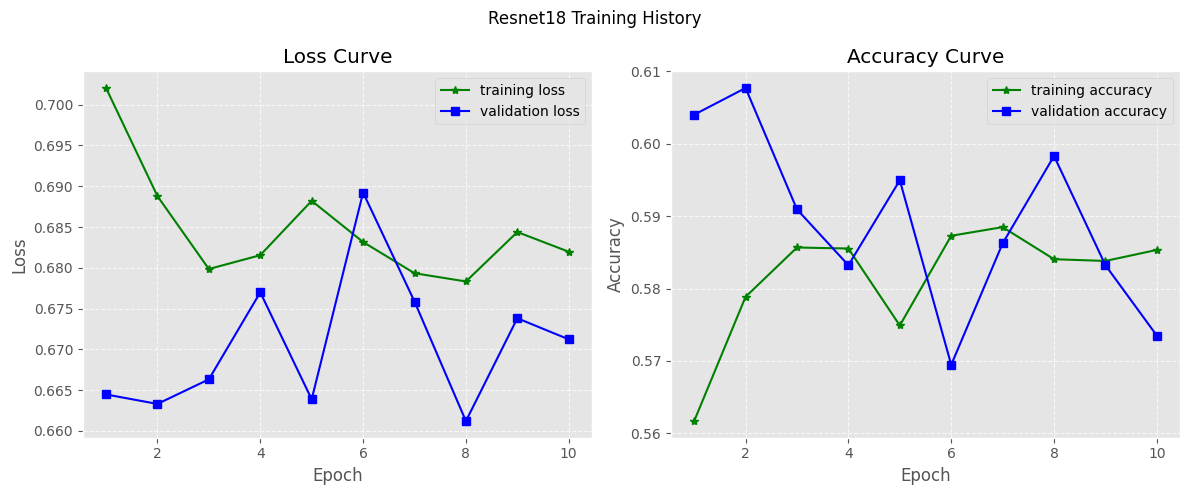

In [12]:
# Plot training history
plot_history(history, "Resnet18 Training History")

torch.Size([32, 256, 256, 3])


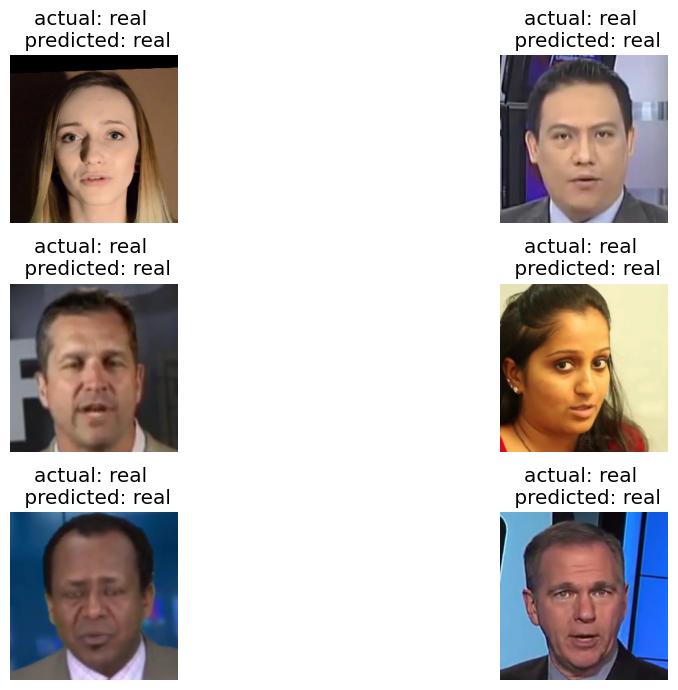

In [14]:
import matplotlib.pyplot as plt
import numpy as np
def visualize_model_prediction(model, dataloader,  num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 7))

    with torch.no_grad():
        for i, (originals, inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            print(originals.shape)
            outputs = model(inputs)
            preds = get_labels(outputs)

            # Get random index
            random_indices = np.random.choice(np.arange(inputs.size()[0]), size = num_images, replace=False)

            for j in random_indices:
                images_so_far += 1
                plt.subplot(num_images // 2, 2, images_so_far)
                plt.axis('off')
                plt.title(f"actual: {CLASS[labels[j].item()]} \n predicted: {CLASS[preds[j]]}")
                plt.tight_layout()
                plt.imshow(originals.cpu().data[j])

                if images_so_far == num_images:
                    return
visualize_model_prediction(model, val_loader, num_images=6)

In [19]:
# Load the model again
checkpoint = torch.load(MODEL_SAVED_PATH)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [20]:
def performance(model, loader, device, model_name, save_path = None, class_names=['real', 'fake']):
    from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
    y_true, y_pred = get_all_predictions(model, loader, device)
    
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy score: {acc:.4f}")
    
    print("Classification Report")
    print(classification_report(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='crest',
        xticklabels=class_names,
        yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{model_name} Confusion Matrix')
    if save_path is not None:
        plt.savefig(save_path)
    plt.tight_layout()
    plt.show()

Getting predictions: 100%|██████████| 95/95 [00:11<00:00,  8.37it/s]

Accuracy score: 0.6046
Classification Report
              precision    recall  f1-score   support

           0       0.61      0.58      0.60      1510
           1       0.60      0.63      0.61      1510

    accuracy                           0.60      3020
   macro avg       0.60      0.60      0.60      3020
weighted avg       0.60      0.60      0.60      3020



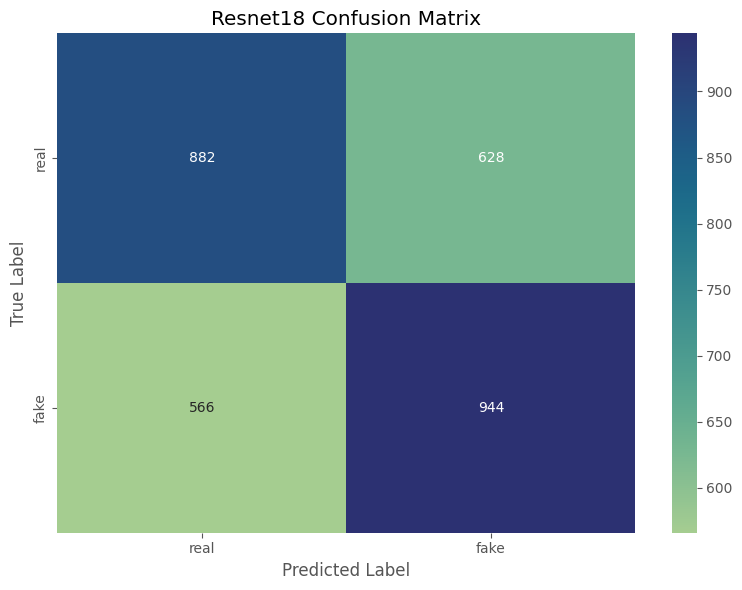

In [21]:
save_path = f"{project_root}/results/{MODEL_NAME}_{TASK_NAME}_cfm.png"
performance(model, test_loader, DEVICE, MODEL_NAME, save_path = save_path)

In [22]:
# Save history
json_path = os.path.join(project_root, f"results/{MODEL_NAME}_{TASK_NAME}_history.json")
save_experiment_json(history, json_path)

History saved to /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/results/Resnet18_deepfake_detection_history.json


## 1.2 Finetuning the model: Unfreezing all layers

As the dataset size is around 21,000 images and DeepFake detection doesn't share the same domain as ImageNet, we decided to unfreeze all layers to fine-tune it

In [23]:
for param in model.parameters():
    param.requires_grad = True

torchsummary.summary(model.to('cpu'), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [24]:

model = model.to(DEVICE)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR_STAGE_2)
criterion = nn.CrossEntropyLoss()

In [25]:
TOTAL_EPOCHS = EPOCHS_STAGE_1 + EPOCHS_STAGE_2
model_save_path = f"{project_root}/model_checkpoints/best_{MODEL_NAME}_{TASK_NAME}_finetuned.pth"

print(f"Training configuration for stage 2 (fine-tuning): LR = {LR_STAGE_2}, EPOCHS = {EPOCHS_STAGE_2}")
for epoch in range(EPOCHS_STAGE_1, TOTAL_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(model, val_loader, criterion, DEVICE)
    
    history["train_losses"].append(train_loss)
    history["train_accuracy"].append(train_acc)
    history["val_losses"].append(valid_loss)
    history["val_accuracy"].append(valid_acc)
    history["val_f1"].append(valid_f1)
    history["val_auc"].append(valid_auc)
    
    print(f"[{epoch + 1}/{TOTAL_EPOCHS} (Fine-Tune)] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}")
    
    if valid_acc > best_acc:
        best_acc = valid_acc
        
        save_checkpoint(model, optimizer, model_save_path) 
        
        # Update best stats
        history["best_accuracy"] = best_acc
        history["best_epoch"] = epoch + 1
        history["MODEL_SAVED_PATH"] = model_save_path
        
    print(f"\t- [current best] epoch: {history['best_epoch']} - acc: {history['best_accuracy']:.4f}\n")

Training configuration for stage 2 (fine-tuning): LR = 1e-05, EPOCHS = 20


Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.43it/s]


[11/30 (Fine-Tune)] train_acc: 0.7120 - train_loss: 0.5532 - valid_acc: 0.7752 - valid_loss: 0.4670
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Resnet18_deepfake_detection_finetuned.pth
	- [current best] epoch: 11 - acc: 0.7752



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.30it/s]


[12/30 (Fine-Tune)] train_acc: 0.8664 - train_loss: 0.3192 - valid_acc: 0.8235 - valid_loss: 0.4076
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Resnet18_deepfake_detection_finetuned.pth
	- [current best] epoch: 12 - acc: 0.8235



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.06it/s]


[13/30 (Fine-Tune)] train_acc: 0.9251 - train_loss: 0.1923 - valid_acc: 0.8406 - valid_loss: 0.3987
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Resnet18_deepfake_detection_finetuned.pth
	- [current best] epoch: 13 - acc: 0.8406



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.52it/s]


[14/30 (Fine-Tune)] train_acc: 0.9575 - train_loss: 0.1209 - valid_acc: 0.8423 - valid_loss: 0.4393
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Resnet18_deepfake_detection_finetuned.pth
	- [current best] epoch: 14 - acc: 0.8423



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  8.57it/s]


[15/30 (Fine-Tune)] train_acc: 0.9730 - train_loss: 0.0795 - valid_acc: 0.8299 - valid_loss: 0.5301
	- [current best] epoch: 14 - acc: 0.8423



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.54it/s]


[16/30 (Fine-Tune)] train_acc: 0.9852 - train_loss: 0.0490 - valid_acc: 0.8463 - valid_loss: 0.4848
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Resnet18_deepfake_detection_finetuned.pth
	- [current best] epoch: 16 - acc: 0.8463



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.51it/s]


[17/30 (Fine-Tune)] train_acc: 0.9888 - train_loss: 0.0360 - valid_acc: 0.8399 - valid_loss: 0.5440
	- [current best] epoch: 16 - acc: 0.8463



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.48it/s]


[18/30 (Fine-Tune)] train_acc: 0.9926 - train_loss: 0.0269 - valid_acc: 0.8440 - valid_loss: 0.5891
	- [current best] epoch: 16 - acc: 0.8463



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.21it/s]


[19/30 (Fine-Tune)] train_acc: 0.9933 - train_loss: 0.0230 - valid_acc: 0.8477 - valid_loss: 0.5746
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Resnet18_deepfake_detection_finetuned.pth
	- [current best] epoch: 19 - acc: 0.8477



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.25it/s]


[20/30 (Fine-Tune)] train_acc: 0.9948 - train_loss: 0.0174 - valid_acc: 0.8436 - valid_loss: 0.6189
	- [current best] epoch: 19 - acc: 0.8477



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  8.56it/s]


[21/30 (Fine-Tune)] train_acc: 0.9941 - train_loss: 0.0176 - valid_acc: 0.8369 - valid_loss: 0.6872
	- [current best] epoch: 19 - acc: 0.8477



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.39it/s]


[22/30 (Fine-Tune)] train_acc: 0.9933 - train_loss: 0.0205 - valid_acc: 0.8419 - valid_loss: 0.6476
	- [current best] epoch: 19 - acc: 0.8477



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  8.56it/s]


[23/30 (Fine-Tune)] train_acc: 0.9963 - train_loss: 0.0135 - valid_acc: 0.8436 - valid_loss: 0.6881
	- [current best] epoch: 19 - acc: 0.8477



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.39it/s]


[24/30 (Fine-Tune)] train_acc: 0.9959 - train_loss: 0.0126 - valid_acc: 0.8530 - valid_loss: 0.7048
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Resnet18_deepfake_detection_finetuned.pth
	- [current best] epoch: 24 - acc: 0.8530



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.44it/s]


[25/30 (Fine-Tune)] train_acc: 0.9949 - train_loss: 0.0146 - valid_acc: 0.8560 - valid_loss: 0.6188
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Resnet18_deepfake_detection_finetuned.pth
	- [current best] epoch: 25 - acc: 0.8560



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  8.57it/s]


[26/30 (Fine-Tune)] train_acc: 0.9941 - train_loss: 0.0165 - valid_acc: 0.8591 - valid_loss: 0.6161
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Resnet18_deepfake_detection_finetuned.pth
	- [current best] epoch: 26 - acc: 0.8591



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  8.59it/s]


[27/30 (Fine-Tune)] train_acc: 0.9952 - train_loss: 0.0147 - valid_acc: 0.8460 - valid_loss: 0.7088
	- [current best] epoch: 26 - acc: 0.8591



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.43it/s]


[28/30 (Fine-Tune)] train_acc: 0.9969 - train_loss: 0.0092 - valid_acc: 0.8500 - valid_loss: 0.7101
	- [current best] epoch: 26 - acc: 0.8591



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.41it/s]


[29/30 (Fine-Tune)] train_acc: 0.9974 - train_loss: 0.0080 - valid_acc: 0.8299 - valid_loss: 0.9175
	- [current best] epoch: 26 - acc: 0.8591



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.40it/s]

[30/30 (Fine-Tune)] train_acc: 0.9969 - train_loss: 0.0095 - valid_acc: 0.8570 - valid_loss: 0.7123
	- [current best] epoch: 26 - acc: 0.8591



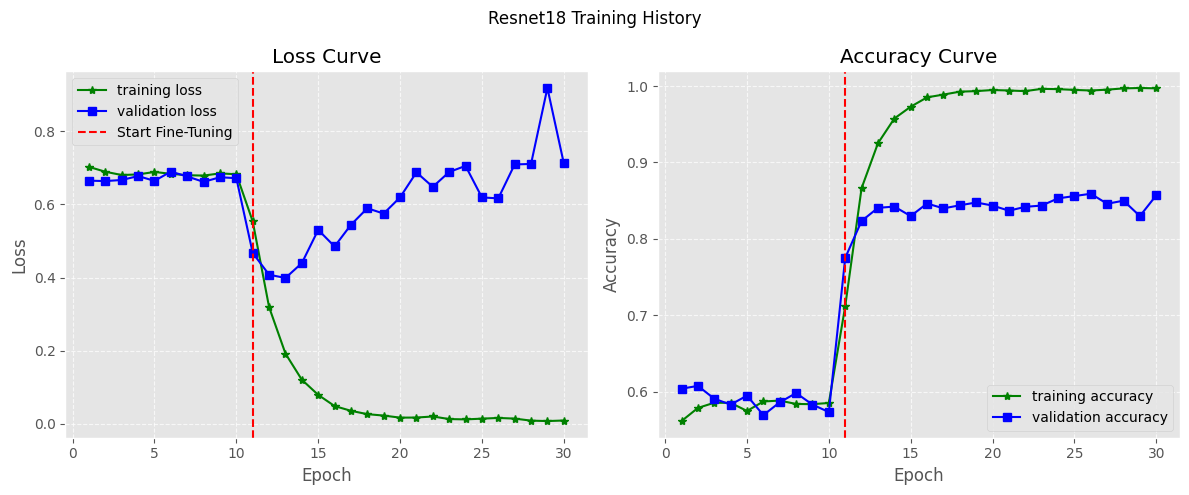

In [26]:
save_path = f"{project_root}/results/{MODEL_NAME}_finetuned_{TASK_NAME}.png"
plot_history(
    history,
    "Resnet18 Training History",
    save_path=save_path,
    start_finetuned_epoch=EPOCHS_STAGE_1 + 1,
)

In [27]:
# Load the model again
checkpoint = torch.load(model_save_path)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

Getting predictions: 100%|██████████| 95/95 [00:11<00:00,  8.49it/s]


Accuracy score: 0.8566
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.86      0.86      1510
           1       0.86      0.85      0.86      1510

    accuracy                           0.86      3020
   macro avg       0.86      0.86      0.86      3020
weighted avg       0.86      0.86      0.86      3020



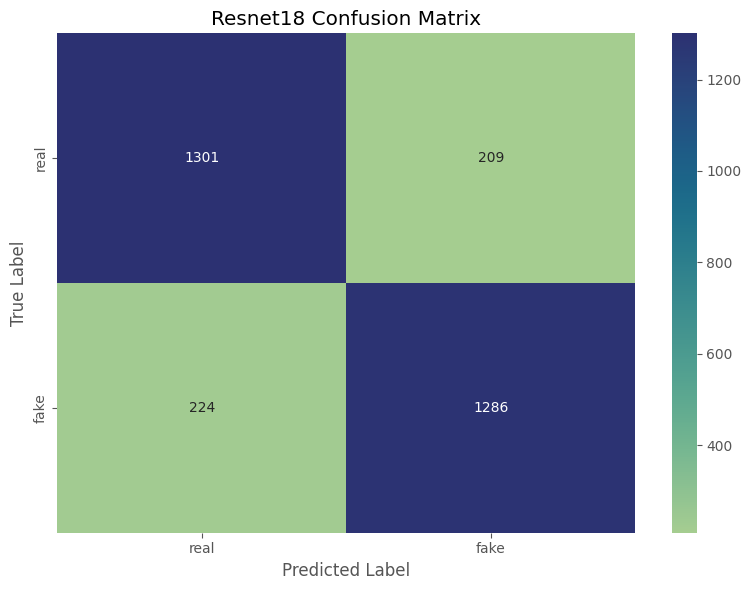

In [28]:
save_path = f"{project_root}/results/{MODEL_NAME}_{TASK_NAME}_finetuned_cfm.png"
performance(model, test_loader, DEVICE, MODEL_NAME, save_path = save_path)

In [29]:
# Save history
json_path = os.path.join(project_root, f"results/{MODEL_NAME}_{TASK_NAME}_finetuned_history.json")
save_experiment_json(history, json_path)

History saved to /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/results/Resnet18_deepfake_detection_finetuned_history.json


## 2. Resnet18 Training with Data Augmentation, Label Smoothing and Weight Decay

In [30]:
train_loader, val_loader, test_loader = get_data_loaders(root_dir = data_path, 
                                                         model_name = "resnet18", 
                                                         batch_size = BATCH_SIZE, 
                                                         use_augmentation = True)

/Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/.venv/lib/python3.11/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2565577].


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

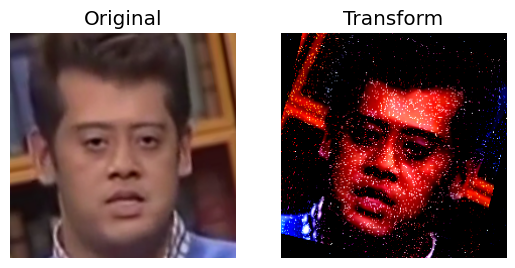

In [31]:
original_images_batch, transformed_images_batch, labels_batch = next(iter(train_loader))

plt.subplot(1, 2, 1)
plt.imshow(original_images_batch[0])
plt.title("Original")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Transform")
plt.imshow(transformed_images_batch[0].permute(1, 2, 0))
plt.axis("off")

###  2.1 Train head only

In [52]:
model = Resnet18DF()
torchsummary.summary(model, (3, 224, 224), batch_size=32)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [32, 64, 112, 112]           9,408
       BatchNorm2d-2         [32, 64, 112, 112]             128
              ReLU-3         [32, 64, 112, 112]               0
         MaxPool2d-4           [32, 64, 56, 56]               0
            Conv2d-5           [32, 64, 56, 56]          36,864
       BatchNorm2d-6           [32, 64, 56, 56]             128
              ReLU-7           [32, 64, 56, 56]               0
            Conv2d-8           [32, 64, 56, 56]          36,864
       BatchNorm2d-9           [32, 64, 56, 56]             128
             ReLU-10           [32, 64, 56, 56]               0
       BasicBlock-11           [32, 64, 56, 56]               0
           Conv2d-12           [32, 64, 56, 56]          36,864
      BatchNorm2d-13           [32, 64, 56, 56]             128
             ReLU-14           [32, 64,

In [53]:
model = model.to(device=DEVICE)
LABEL_SMOOTHING = 0.1
WEIGHT_DECAY = 1e-2

optimizer = torch.optim.Adam(params=model.parameters(), lr=LR_STAGE_1, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

In [54]:
history_aug = {
    'model_name': MODEL_NAME,
    'model_saved_path': '',
    'weight_decay': WEIGHT_DECAY,
    'label_smoothing': LABEL_SMOOTHING,
    'train_losses': [],
    'val_losses': [],
    'train_accuracy': [],
    'val_accuracy': [],
    'val_f1': [],
    'val_auc': [],
    'best_accuracy': [],
    'best_epoch': [],
}

best_acc = 0.0

In [55]:

MODEL_SAVED_PATH = os.path.join(
    project_root, f"model_checkpoints/{MODEL_NAME}_augmentation_{TASK_NAME}.pth"
)

print(f"Training configuration for stage 1: LR = {LR_STAGE_1}, EPOCHS = {EPOCHS_STAGE_1}")

for epoch in range(EPOCHS_STAGE_1):
    # Train
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, DEVICE
    )

    # Evaluate
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(
        model, val_loader, criterion, DEVICE
    )

    print(
        f"[{epoch + 1}/{EPOCHS_STAGE_1}] train_acc: {train_acc:.4f} - train_loss: {train_loss:.4f} - valid_acc: {valid_acc:.4f} - valid_loss: {valid_loss:.4f}"
    )
    # Record metrics
    history_aug["train_losses"].append(train_loss)
    history_aug["val_losses"].append(valid_loss)
    history_aug["train_accuracy"].append(train_acc)
    history_aug["val_accuracy"].append(valid_acc)
    history_aug["val_f1"].append(valid_f1)
    history_aug["val_auc"].append(valid_auc)

    # Save Best Model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_checkpoint(model, optimizer, MODEL_SAVED_PATH)

        # Update best stats
        history_aug["best_accuracy"] = best_acc
        history_aug["best_epoch"] = epoch + 1
        history_aug["MODEL_SAVED_PATH"] = MODEL_SAVED_PATH

    print(
        f"\t- [current best] epoch: {history_aug['best_epoch']} - acc: {history_aug['best_accuracy']:.4f}\n"
    )

Training configuration for stage 1: LR = 0.001, EPOCHS = 10


Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.28it/s]


[1/10] train_acc: 0.5352 - train_loss: 0.7123 - valid_acc: 0.5607 - valid_loss: 0.6836
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Resnet18_augmentation_deepfake_detection.pth
	- [current best] epoch: 1 - acc: 0.5607



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  8.58it/s]


[2/10] train_acc: 0.5503 - train_loss: 0.6999 - valid_acc: 0.5550 - valid_loss: 0.6871
	- [current best] epoch: 1 - acc: 0.5607



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.08it/s]


[3/10] train_acc: 0.5526 - train_loss: 0.6992 - valid_acc: 0.5779 - valid_loss: 0.6787
Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/Resnet18_augmentation_deepfake_detection.pth
	- [current best] epoch: 3 - acc: 0.5779



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  8.59it/s]


[4/10] train_acc: 0.5566 - train_loss: 0.6989 - valid_acc: 0.5477 - valid_loss: 0.6907
	- [current best] epoch: 3 - acc: 0.5779



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.20it/s]


[5/10] train_acc: 0.5528 - train_loss: 0.6984 - valid_acc: 0.5111 - valid_loss: 0.7418
	- [current best] epoch: 3 - acc: 0.5779



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  8.71it/s]


[6/10] train_acc: 0.5527 - train_loss: 0.6997 - valid_acc: 0.5584 - valid_loss: 0.6855
	- [current best] epoch: 3 - acc: 0.5779



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.40it/s]


[7/10] train_acc: 0.5585 - train_loss: 0.6952 - valid_acc: 0.5735 - valid_loss: 0.6804
	- [current best] epoch: 3 - acc: 0.5779



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  8.86it/s]


[8/10] train_acc: 0.5490 - train_loss: 0.7018 - valid_acc: 0.5550 - valid_loss: 0.6869
	- [current best] epoch: 3 - acc: 0.5779



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  8.79it/s]


[9/10] train_acc: 0.5485 - train_loss: 0.6978 - valid_acc: 0.5232 - valid_loss: 0.7128
	- [current best] epoch: 3 - acc: 0.5779



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  8.62it/s]

[10/10] train_acc: 0.5514 - train_loss: 0.6999 - valid_acc: 0.5601 - valid_loss: 0.6831
	- [current best] epoch: 3 - acc: 0.5779



In [56]:
# Load the best state again
checkpoint = torch.load(MODEL_SAVED_PATH)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

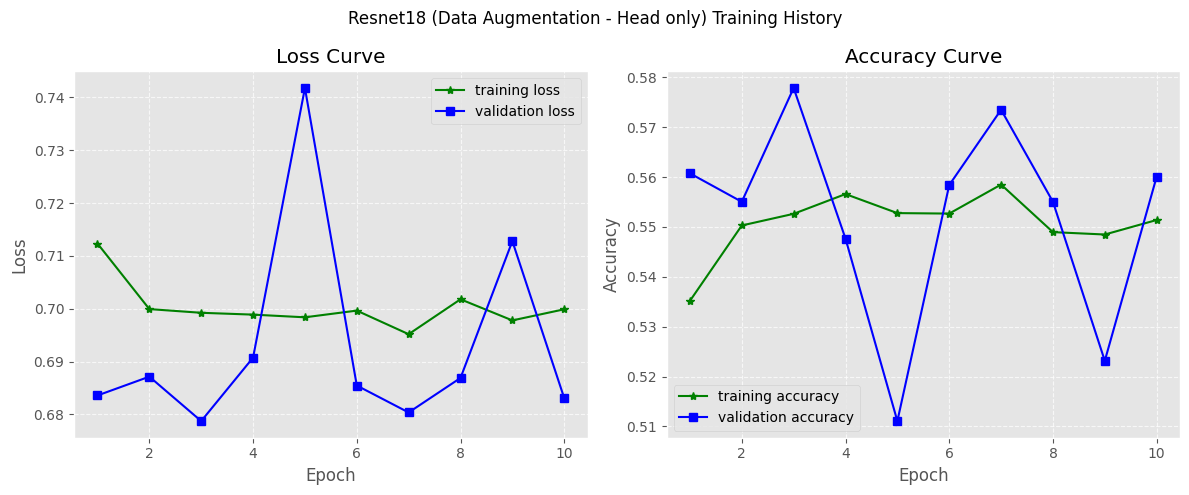

In [57]:
model_saved_name = f"{MODEL_NAME}_augmentation_{TASK_NAME}"
plot_history(
    history_aug,
    "Resnet18 (Data Augmentation - Head only) Training History",
    f"{model_saved_name}.png",
)

### 2.2 Fine-tuning by unfreezing all layers

In [58]:
for param in model.parameters():
    param.requires_grad = True

torchsummary.summary(model.to('cpu'), (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [59]:
model = model.to(device=DEVICE)
LABEL_SMOOTHING = 0.1
WEIGHT_DECAY = 1e-2

optimizer = torch.optim.Adam(params=model.parameters(), lr=LR_STAGE_2, weight_decay=WEIGHT_DECAY)
criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

In [60]:
TOTAL_EPOCHS = EPOCHS_STAGE_1 + EPOCHS_STAGE_2
model_save_path = f"{project_root}/model_checkpoints/best_{MODEL_NAME}_{TASK_NAME}_finetuned.pth"

print(f"Training configuration for stage 2: LR = {LR_STAGE_2}, EPOCHS = {EPOCHS_STAGE_2}")
for epoch in range(EPOCHS_STAGE_1, TOTAL_EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    valid_loss, valid_acc, valid_f1, valid_auc = evaluate(model, val_loader, criterion, DEVICE)
    
    # Record metrics
    history_aug["train_losses"].append(train_loss)
    history_aug["val_losses"].append(valid_loss)
    history_aug["train_accuracy"].append(train_acc)
    history_aug["val_accuracy"].append(valid_acc)
    history_aug["val_f1"].append(valid_f1)
    history_aug["val_auc"].append(valid_auc)

    # Save Best Model (based on Accuracy)
    if valid_acc > best_acc:
        best_acc = valid_acc
        save_checkpoint(model, optimizer, model_save_path)

        # Update best stats
        history_aug["best_accuracy"] = best_acc
        history_aug["best_epoch"] = epoch + 1
        history_aug["MODEL_SAVED_PATH"] = model_save_path
        
    print(f"\t- [current best] epoch: {history_aug['best_epoch']} - acc: {history_aug['best_accuracy']:.4f}\n")

Training configuration for stage 2: LR = 1e-05, EPOCHS = 20


Evaluating: 100%|██████████| 94/94 [00:10<00:00,  8.83it/s]


Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Resnet18_deepfake_detection_finetuned.pth
	- [current best] epoch: 11 - acc: 0.7017



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.04it/s]


Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Resnet18_deepfake_detection_finetuned.pth
	- [current best] epoch: 12 - acc: 0.7393



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  8.86it/s]


Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Resnet18_deepfake_detection_finetuned.pth
	- [current best] epoch: 13 - acc: 0.7711



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.48it/s]


Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Resnet18_deepfake_detection_finetuned.pth
	- [current best] epoch: 14 - acc: 0.7735



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.24it/s]


Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Resnet18_deepfake_detection_finetuned.pth
	- [current best] epoch: 15 - acc: 0.7883



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.19it/s]


Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Resnet18_deepfake_detection_finetuned.pth
	- [current best] epoch: 16 - acc: 0.7886



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.32it/s]


Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Resnet18_deepfake_detection_finetuned.pth
	- [current best] epoch: 17 - acc: 0.7970



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.33it/s]


	- [current best] epoch: 17 - acc: 0.7970



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.22it/s]


Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Resnet18_deepfake_detection_finetuned.pth
	- [current best] epoch: 19 - acc: 0.8010



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.25it/s]


Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Resnet18_deepfake_detection_finetuned.pth
	- [current best] epoch: 20 - acc: 0.8044



Evaluating: 100%|██████████| 94/94 [00:12<00:00,  7.79it/s]


Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Resnet18_deepfake_detection_finetuned.pth
	- [current best] epoch: 21 - acc: 0.8124



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.37it/s]


Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Resnet18_deepfake_detection_finetuned.pth
	- [current best] epoch: 22 - acc: 0.8131



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.48it/s]


Checkpoint saved: /Users/mac/Desktop/Code/Personal_Project/VNUK/deep_fake_detection/model_checkpoints/best_Resnet18_deepfake_detection_finetuned.pth
	- [current best] epoch: 23 - acc: 0.8218



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.51it/s]


	- [current best] epoch: 23 - acc: 0.8218



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.41it/s]


	- [current best] epoch: 23 - acc: 0.8218



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  8.60it/s]


	- [current best] epoch: 23 - acc: 0.8218



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.44it/s]


	- [current best] epoch: 23 - acc: 0.8218



Evaluating: 100%|██████████| 94/94 [00:11<00:00,  8.41it/s]


	- [current best] epoch: 23 - acc: 0.8218



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  8.98it/s]


	- [current best] epoch: 23 - acc: 0.8218



Evaluating: 100%|██████████| 94/94 [00:10<00:00,  8.99it/s]

	- [current best] epoch: 23 - acc: 0.8218



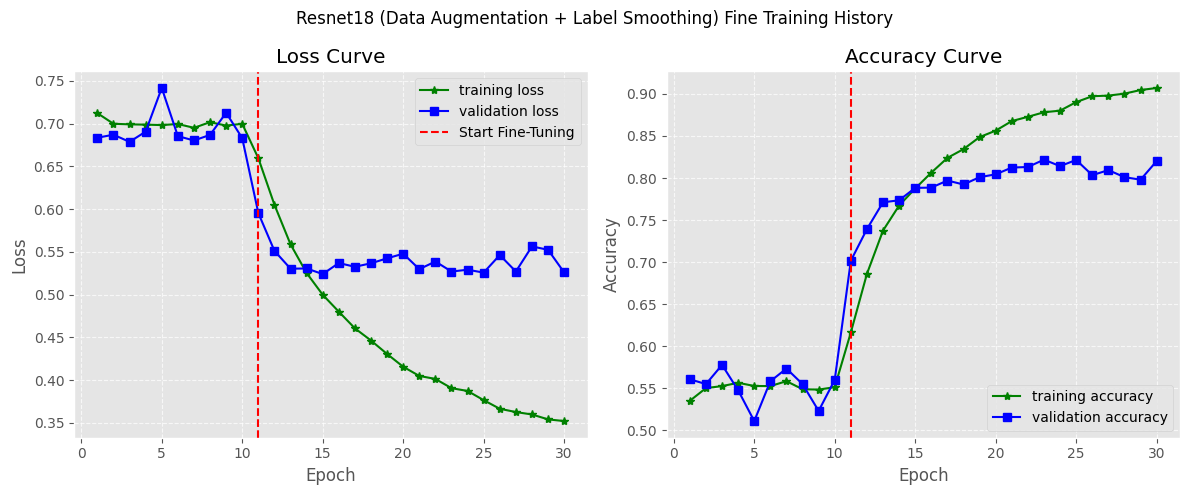

In [62]:
model_saved_name = f"{MODEL_NAME}_augmentation_finetuned_{TASK_NAME}"
plot_history(
    history_aug,
    "Resnet18 (Data Augmentation + Label Smoothing) Fine Training History",
    f"{model_saved_name}.png",
    start_finetuned_epoch=EPOCHS_STAGE_1 + 1
    
)

In [65]:
# Load the model again
checkpoint = torch.load(model_save_path)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

Getting predictions: 100%|██████████| 95/95 [00:11<00:00,  8.00it/s]


Accuracy score: 0.8275
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1510
           1       0.81      0.86      0.83      1510

    accuracy                           0.83      3020
   macro avg       0.83      0.83      0.83      3020
weighted avg       0.83      0.83      0.83      3020



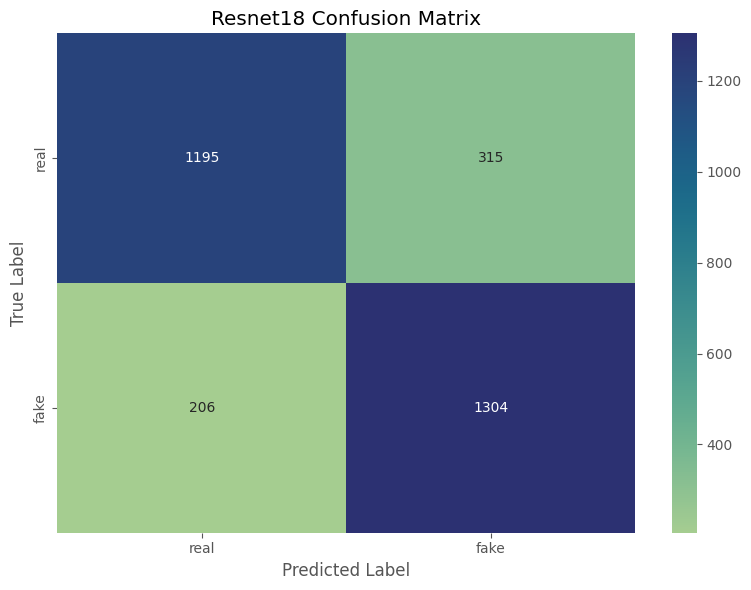

In [66]:
save_path = f"{project_root}/results/{MODEL_NAME}_{TASK_NAME}_augmentation_finetuned_cfm.png"
performance(model, test_loader, DEVICE, MODEL_NAME, save_path = save_path)